In [ ]:
# Install required libraries if not already installed


# Import necessary libraries
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt



Note: you may need to restart the kernel to use updated packages.


In [21]:
class PlantDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.data = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.data.iloc[idx, 0])  # First column = image path
        label = self.data.iloc[idx, 1]  # Second column = label
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


In [ ]:
# Define transformations for training and validation/test

# Load CSV files
train_df = pd.read_csv('dataset/train.csv')
val_df = pd.read_csv('dataset/val.csv')
test_df = pd.read_csv('dataset/test.csv')


train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# val_test_transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Ensure the image size is consistent
#     transforms.ToTensor(),         # Convert to tensor
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#         # Normalize with same values
# ])

# Create datasets with appropriate transforms
train_dataset = PlantDataset(dataframe=train_df, root_dir='dataset/', transform=train_transform)
val_dataset = PlantDataset(dataframe=val_df, root_dir='dataset/', transform=train_transform)
test_dataset = PlantDataset(dataframe=test_df, root_dir='dataset/', transform=train_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [23]:
class ImprovedPlantClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedPlantClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)  # Dropout to prevent overfitting
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 256 * 14 * 14)  # Flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedPlantClassifier(num_classes=30).to(device)


In [24]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


In [25]:
# Initialize TensorBoard
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/plant_classifier_plswrk')

# Training loop
num_epochs = 60
train_losses, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate and log training loss
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    writer.add_scalar('Training Loss', avg_loss, epoch)

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    val_accuracies.append(accuracy)
    writer.add_scalar('Validation Accuracy', accuracy, epoch)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")

    # Step the learning rate scheduler
    scheduler.step()

writer.close()


Epoch 1/60, Loss: 2.7276, Validation Accuracy: 34.03%
Epoch 2/60, Loss: 2.2931, Validation Accuracy: 39.60%
Epoch 3/60, Loss: 2.1053, Validation Accuracy: 42.93%
Epoch 4/60, Loss: 1.9697, Validation Accuracy: 50.00%
Epoch 5/60, Loss: 1.8498, Validation Accuracy: 51.87%
Epoch 6/60, Loss: 1.6529, Validation Accuracy: 57.43%
Epoch 7/60, Loss: 1.5377, Validation Accuracy: 58.00%
Epoch 8/60, Loss: 1.4833, Validation Accuracy: 60.80%
Epoch 9/60, Loss: 1.4111, Validation Accuracy: 62.23%
Epoch 10/60, Loss: 1.3412, Validation Accuracy: 62.97%
Epoch 11/60, Loss: 1.2167, Validation Accuracy: 66.80%
Epoch 12/60, Loss: 1.1658, Validation Accuracy: 67.90%
Epoch 13/60, Loss: 1.1234, Validation Accuracy: 66.00%
Epoch 14/60, Loss: 1.0765, Validation Accuracy: 68.20%
Epoch 15/60, Loss: 1.0360, Validation Accuracy: 68.17%
Epoch 16/60, Loss: 0.9565, Validation Accuracy: 69.67%
Epoch 17/60, Loss: 0.9391, Validation Accuracy: 69.93%
Epoch 18/60, Loss: 0.9065, Validation Accuracy: 69.57%
Epoch 19/60, Loss: 

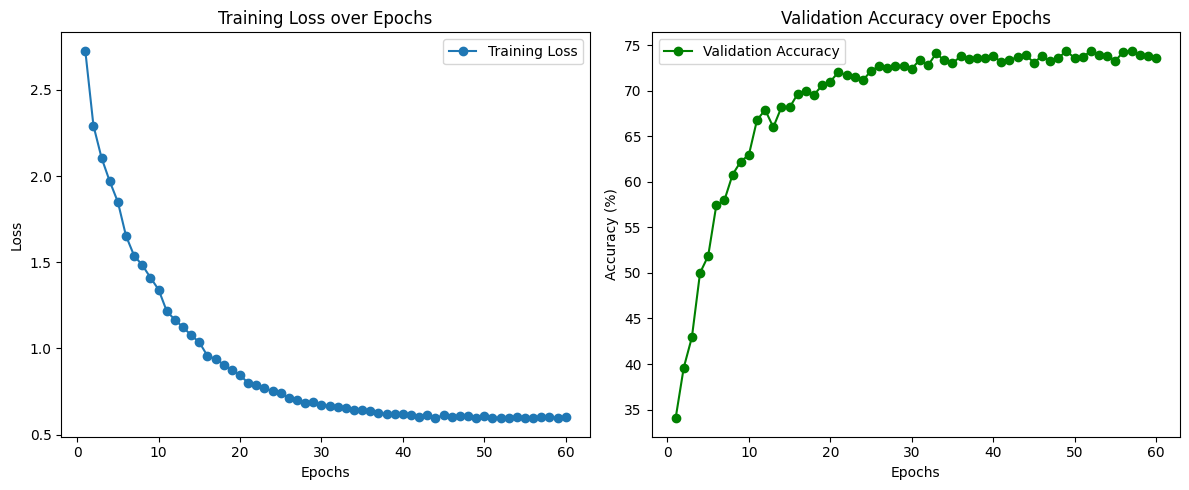

In [26]:
# Plot training loss and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy', marker='o', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
model.eval()
correct, total = 0, 0
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 71.85%


In [29]:
num_classes = 30  # Replace with the actual number of classes
class_names = [f"Class_{i}" for i in range(num_classes)]
print(class_names)


['Class_0', 'Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6', 'Class_7', 'Class_8', 'Class_9', 'Class_10', 'Class_11', 'Class_12', 'Class_13', 'Class_14', 'Class_15', 'Class_16', 'Class_17', 'Class_18', 'Class_19', 'Class_20', 'Class_21', 'Class_22', 'Class_23', 'Class_24', 'Class_25', 'Class_26', 'Class_27', 'Class_28', 'Class_29']


0:aloevera
1:banana
2:bilimbi
3:cantaloupe
4:cassava
5:coconut
6:corn
7:cucumber
8:curcuma
9:eggplant
10:galangal
11:ginger
12:guava
13:kale
14:longbeans
15:mango
16:melon
17:orange
18:paddy
19:papaya
20:peperchili
21:pineapple
22:pomelo
23:shallot
24:soybeans
25:spinach
26:sweetpotatoes
27:tobacco
28:waterapple
29:watermelon

In [1]:
import seaborn as sns

Classification Report:
              precision    recall  f1-score   support

     Class_0       0.85      0.71      0.78       200
     Class_1       0.58      0.47      0.52       200
     Class_2       0.63      0.62      0.62       200
     Class_3       0.39      0.39      0.39       200
     Class_4       0.64      0.72      0.68       200
     Class_5       0.70      0.38      0.49       200
     Class_6       0.73      0.84      0.78       200
     Class_7       0.75      0.82      0.78       200
     Class_8       0.76      0.80      0.78       200
     Class_9       0.76      0.87      0.81       200
    Class_10       0.75      0.87      0.81       200
    Class_11       0.63      0.70      0.66       200
    Class_12       0.78      0.77      0.77       200
    Class_13       0.80      0.68      0.74       200
    Class_14       0.85      0.89      0.87       200
    Class_15       0.51      0.51      0.51       200
    Class_16       0.42      0.36      0.39       200
    

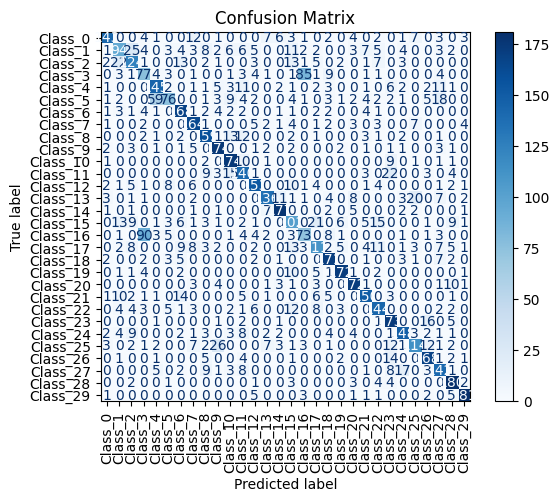

F1 Score (Macro): 0.7127
F1 Score (Micro): 0.7175
F1 Score (Weighted): 0.7127


In [31]:
# Evaluate on test data
from sklearn.metrics import confusion_matrix, classification_report, f1_score, ConfusionMatrixDisplay

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.title("Confusion Matrix")
plt.show()

# F1 Score
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_micro = f1_score(y_true, y_pred, average='micro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print(f"F1 Score (Macro): {f1_macro:.4f}")
print(f"F1 Score (Micro): {f1_micro:.4f}")
print(f"F1 Score (Weighted): {f1_weighted:.4f}")



In [32]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/plant_classifier_plswrk')


In [33]:
# Save the trained model
torch.save(model.state_dict(), 'our_classifier.pth')


# Assuming `model` is your PyTorch model
# Save only the state_dict (weights and biases)
torch.save(model.state_dict(), "our_classifier.pkl")



print("Model saved")


Model saved


In [35]:
import torch
torch.cuda.empty_cache()
